In [1]:
# import packages
import pandas as pd
import os
import numpy as np
import seaborn as sns
import missingno as msno
import sklearn 
from plotnine import ggplot, aes, geom_line
import math

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from skranger.ensemble import RangerForestRegressor
from sklearn.metrics import mean_squared_error

import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [2]:
# Path to the folder containing the chunked data
folder_path = "../Output_datasets/Google_mobility_flow_prediction/Chunked_merged_data"

In [3]:
# List of dataframes to store the data from each file
chunks = []
# Loop through each file in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a CSV file
    if filename.endswith(".csv"):
        # Load the file into a dataframe
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        # Append the dataframe to the list
        chunks.append(df)

In [4]:
# Sanity check: concatenate all chunks, keep unique and look at number of observations
raw_data = pd.concat(chunks).drop_duplicates()

# conditionally select rows based on a condition
len(raw_data)

273600

<AxesSubplot:>

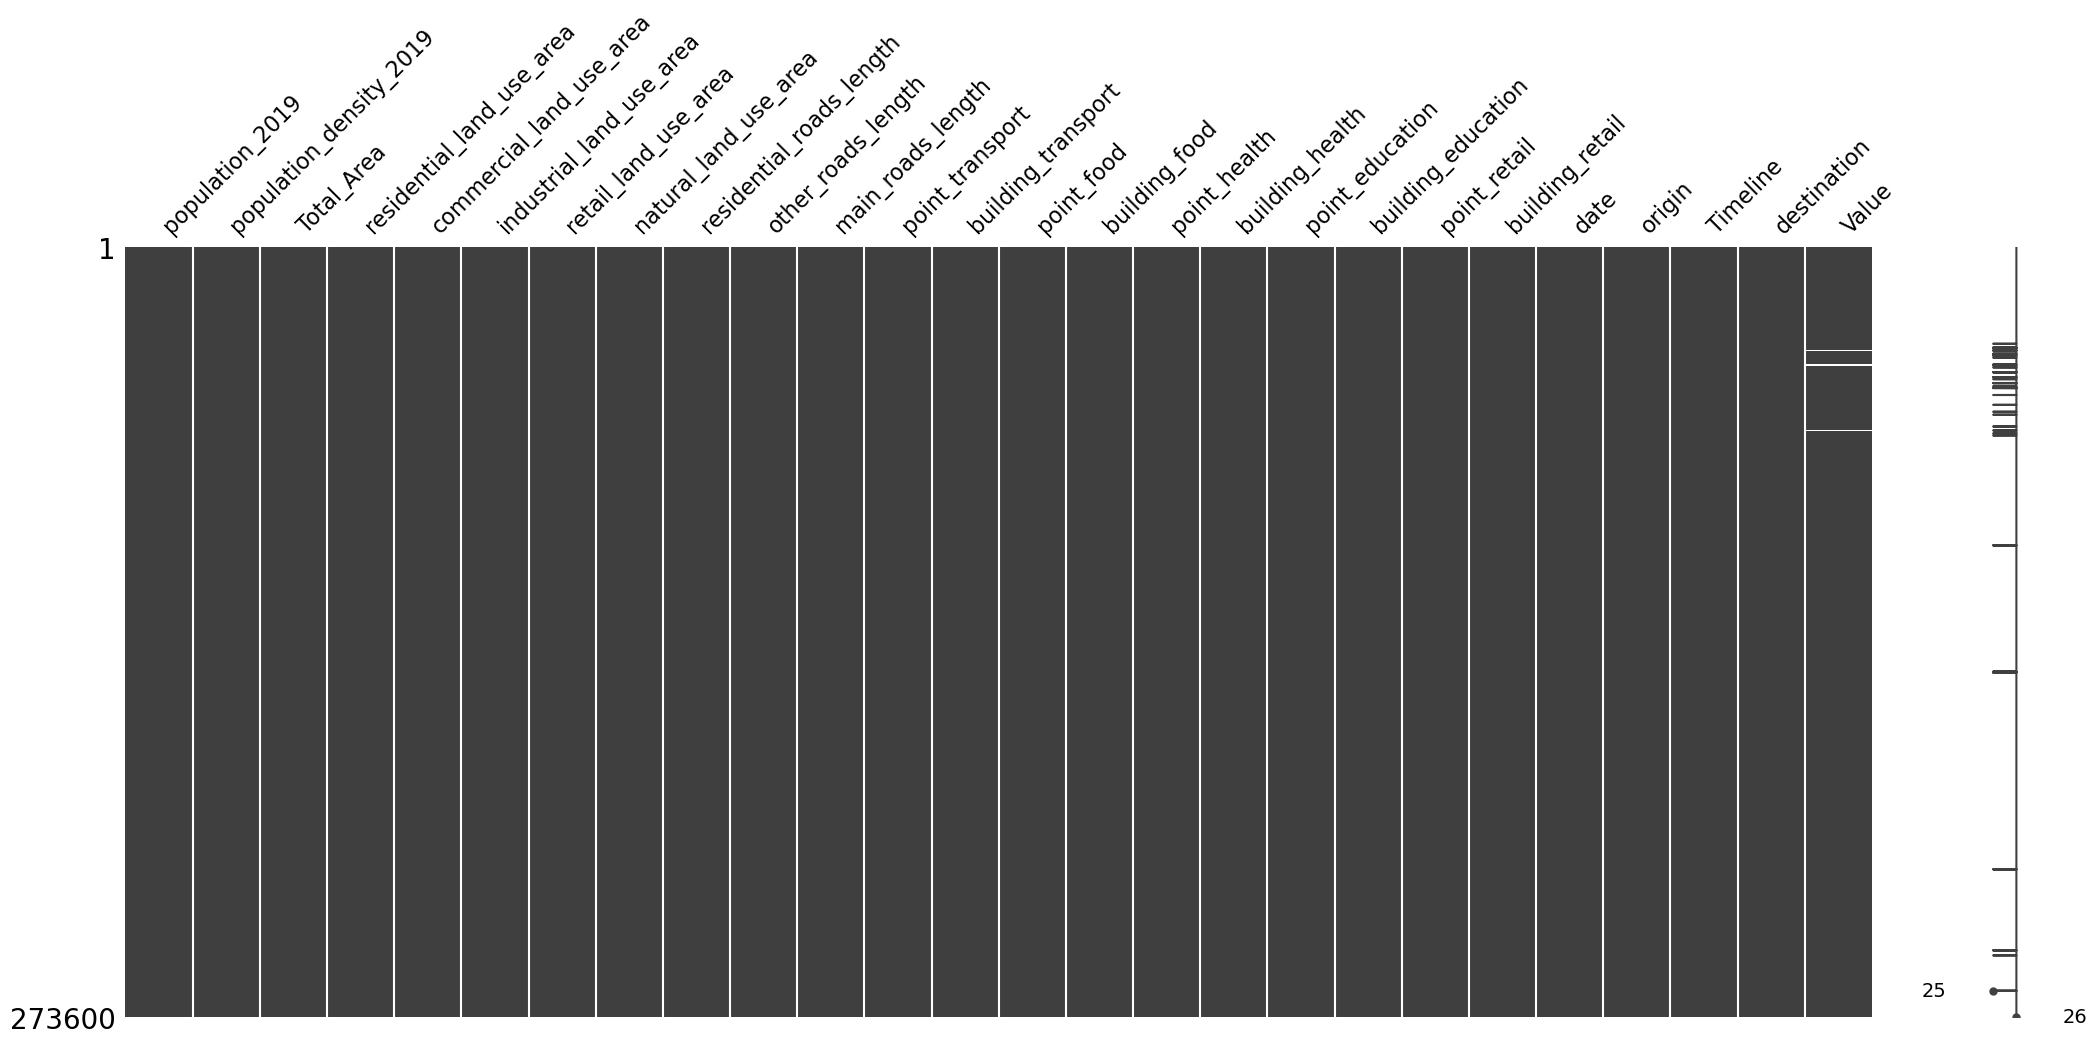

In [5]:
msno.matrix(raw_data)

In [6]:
to_filter = raw_data.isna().sum()
to_filter[to_filter > 0]

Value    625
dtype: int64

In [7]:
missings = raw_data [raw_data.isna().any(axis=1)]
missings.to_csv('missings_google_mobility.csv')
missings

,population_2019,population_density_2019,Total_Area,residential_land_use_area,commercial_land_use_area,industrial_land_use_area,retail_land_use_area,natural_land_use_area,residential_roads_length,other_roads_length,...,building_health,point_education,building_education,point_retail,building_retail,date,origin,Timeline,destination,Value
34385,3017804,57.992836,"137,732",0.779789,0.033873,0.022326,0.006207,1070.944494,1.189866e+08,9.134656e+07,...,18,1829,52,528,4,2020-08-18,US-AR,185,parks_percent_change_from_baseline,NaN
34386,3017804,57.992836,"137,732",0.779789,0.033873,0.022326,0.006207,1070.944494,1.189866e+08,9.134656e+07,...,18,1829,52,528,4,2020-08-19,US-AR,186,parks_percent_change_from_baseline,NaN
34387,3017804,57.992836,"137,732",0.779789,0.033873,0.022326,0.006207,1070.944494,1.189866e+08,9.134656e+07,...,18,1829,52,528,4,2020-08-20,US-AR,187,parks_percent_change_from_baseline,NaN
34388,3017804,57.992836,"137,732",0.779789,0.033873,0.022326,0.006207,1070.944494,1.189866e+08,9.134656e+07,...,18,1829,52,528,4,2020-08-21,US-AR,188,parks_percent_change_from_baseline,NaN
34402,3017804,57.992836,"137,732",0.779789,0.033873,0.022326,0.006207,1070.944494,1.189866e+08,9.134656e+07,...,18,1829,52,528,4,2020-09-04,US-AR,202,parks_percent_change_from_baseline,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36017,973764,499.747759,"6,446",7.077454,0.055684,0.837460,0.118469,142.937903,7.165999e+06,1.240155e+07,...,8,33,15,239,1,2022-08-20,US-DE,917,parks_percent_change_from_baseline,NaN
36024,973764,499.747759,"6,446",7.077454,0.055684,0.837460,0.118469,142.937903,7.165999e+06,1.240155e+07,...,8,33,15,239,1,2022-08-27,US-DE,924,parks_percent_change_from_baseline,NaN
36031,973764,499.747759,"6,446",7.077454,0.055684,0.837460,0.118469,142.937903,7.165999e+06,1.240155e+07,...,8,33,15,239,1,2022-09-03,US-DE,931,parks_percent_change_from_baseline,NaN
36038,973764,499.747759,"6,446",7.077454,0.055684,0.837460,0.118469,142.937903,7.165999e+06,1.240155e+07,...,8,33,15,239,1,2022-09-10,US-DE,938,parks_percent_change_from_baseline,NaN


In [8]:
data = raw_data.copy()
# Fill across the row (temporary solution)
data = data.bfill(axis ='rows')

In [9]:
print(data.dtypes)

population_2019                int64
population_density_2019      float64
Total_Area                    object
residential_land_use_area    float64
commercial_land_use_area     float64
industrial_land_use_area     float64
retail_land_use_area         float64
natural_land_use_area        float64
residential_roads_length     float64
other_roads_length           float64
main_roads_length            float64
point_transport                int64
building_transport             int64
point_food                     int64
building_food                  int64
point_health                   int64
building_health                int64
point_education                int64
building_education             int64
point_retail                   int64
building_retail                int64
date                          object
origin                        object
Timeline                       int64
destination                   object
Value                        float64
dtype: object


In [10]:
# remove the separators from area and convert to numeric
data['Total_Area'] = data['Total_Area'].str.replace(r',', r'', regex=True)

In [11]:
data['Total_Area'] = pd.to_numeric(data['Total_Area'])
print(data.dtypes)

population_2019                int64
population_density_2019      float64
Total_Area                     int64
residential_land_use_area    float64
commercial_land_use_area     float64
industrial_land_use_area     float64
retail_land_use_area         float64
natural_land_use_area        float64
residential_roads_length     float64
other_roads_length           float64
main_roads_length            float64
point_transport                int64
building_transport             int64
point_food                     int64
building_food                  int64
point_health                   int64
building_health                int64
point_education                int64
building_education             int64
point_retail                   int64
building_retail                int64
date                          object
origin                        object
Timeline                       int64
destination                   object
Value                        float64
dtype: object


In [12]:
data = data.drop('date', axis=1)

In [13]:
data['origin'] = data['origin'].astype('category')
data['destination'] = data['destination'].astype('category')
print(data.dtypes)

population_2019                 int64
population_density_2019       float64
Total_Area                      int64
residential_land_use_area     float64
commercial_land_use_area      float64
industrial_land_use_area      float64
retail_land_use_area          float64
natural_land_use_area         float64
residential_roads_length      float64
other_roads_length            float64
main_roads_length             float64
point_transport                 int64
building_transport              int64
point_food                      int64
building_food                   int64
point_health                    int64
building_health                 int64
point_education                 int64
building_education              int64
point_retail                    int64
building_retail                 int64
origin                       category
Timeline                        int64
destination                  category
Value                         float64
dtype: object


In [18]:
h2o.init(nthreads=-1, max_mem_size = "32g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_371"; Java(TM) SE Runtime Environment (build 1.8.0_371-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.371-b11, mixed mode)
  Starting server from /Users/ramzi.chariag/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmpt5ndv9yy
  JVM stdout: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmpt5ndv9yy/h2o_ramzi_chariag_started_from_python.out
  JVM stderr: /var/folders/07/r8yrsw3j65v2937ssq1kyq8r0000gn/T/tmpt5ndv9yy/h2o_ramzi_chariag_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Vienna
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.3
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_ramzi_chariag_93ojkf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,28.43 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [19]:
data_out = pd.DataFrame()

for chunk in chunks:


    drf = H2ORandomForestEstimator(ntrees = 50, min_rows=10, nfolds = 5, stopping_metric= 'rmse', seed = 42)

    # define the hyperparameter grid
    tune_grid = {
        'max_depth': [15, 18, 20],
        'mtries': [21, 23]
        }

    drf_grid = H2OGridSearch(model=drf,
                            hyper_params=tune_grid,
                            parallelism = 0
                            ) 

    data = chunk.copy()

    # define the list of features to be used 
    features = list(data.columns)
    features = features.remove ('Value')

    # Fill missing target (temporary solution)
    #data = data.bfill(axis ='rows')
    data['Value'] = data['Value'].fillna(0)

    # remove the separators from area and convert to numeric
    data['Total_Area'] = data['Total_Area'].str.replace(r',', r'', regex=True)
    data['Total_Area'] = pd.to_numeric(data['Total_Area'])


    # use categorical variables for origin and destination
    data['origin'] = data['origin'].astype('category')
    data['destination'] = data['destination'].astype('category')

    # Drop date
    data = data.drop('date', axis=1)

    # Create lag 
    data['lagged_Value'] = data.groupby(['origin', 'destination'])['Value'].shift(1)

    # Shift traget
    data['Value_target'] = data.groupby(['origin', 'destination'])['Value'].shift(-1)

    # keep the last year 
    X_predic = data[data['Timeline'] == max(data['Timeline'])].drop(['Value_target'], axis=1)

    # Drop because of shift
    data.dropna(inplace=True)

    # Convert to h2o dataframe
    data = h2o.H2OFrame(data)
    X_predic_h2o = h2o.H2OFrame(X_predic)

    # Dataset split
    data_split = data.split_frame(ratios=[0.8], seed = 42)
    data_train = data_split[0]
    data_test = data_split[1]

    # Train using 5 fold CV plus grid search and predict using best model 
    drf_grid.train(x = features, y = 'Value_target', training_frame = data_train, validation_frame = data_test)
    drf_sorted_grid = drf_grid.get_grid(sort_by = 'rmse', decreasing = False)
    best_model = drf_sorted_grid[0]
    y_predic_h2o = best_model.predict(X_predic_h2o)
    y_predic = y_predic_h2o.as_data_frame() 

    X_predic['prediction'] = y_predic['predict'].to_numpy()

    data_out = pd.concat([data_out, X_predic])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf Grid Build progress: |████████████████████████

In [20]:
# Save results
results = pd.DataFrame({
    'Timeline': data_out['Timeline']+1,
    'origin': data_out['origin'],
    'destination': data_out['destination'],
    'prediction': data_out['prediction']
})

results.to_csv('google_mobility_prediction.csv')

In [21]:
h2o.cluster().shutdown()

H2O session _sid_b351 closed.
